# A Simple Deterministic Example with a Mortality Crisis

In [28]:
import os
os.chdir('..')
from households import *
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

In [29]:
from households import *

In [30]:
class MortalityCrisis(object):
    """ A simulation-wide population crisis event with customizable start year, duration, and removal probabilities.
    
    When called, takes world as an argument and iterates through all community and household objects, 
    deciding for each person object whether or not they will be removed from the simulation based on 
    rates within plaguetab. Records removed people within list.
    
    Parameters
    ----------
    startyear: int
        Defines starting year of crisis.
    duration: int
        Defines lenth and subsequent ending year of crisis.
    plaguetab: list of 3 households.AgeTable
        List of agetables for determining probability of removal based on household size.
        
    Attributes
    ----------
    killedbyplague: list
        list of those killed by the mortality crisis over entire duration.
    """
    def __init__(self, startyear, duration, plaguetab):
        self.startyear = startyear
        self.duration = duration
        if type(plaguetab) != list or len(plaguetab) != 3:
            raise TypeError('plaguetab not a list of length 3')
        if all( [isinstance(pt, AgeTable) for pt in plaguetab] ) == False:
            raise TypeError('plaguetab values not of type AgeTable')
        self.plaguetab = plaguetab
        self.killedbyplague = []
    
    def __call__(self, world):
        """ Checks if the mortality crisis happens for a given year and appends removed to list.
        
        Parameters
        ----------
        world: World
            The world object that the crisis will affect.
        """
        
        if world.year < self.startyear or world.year > self.startyear + self.duration:
            pass
        else:
            for community in world.communities:
                for house in community.houses:
                    housepop = len(house.people)
                    if housepop == 0: #0 because housepop is int
                        next                    
                    elif housepop <= 5:
                        i = 0
                    elif 5 < housepop <= 10:
                        i = 1
                    elif housepop > 10:
                        i = 2
                    else:
                        #something has gone horribly wrong
                        raise ValueError('housepop is not a recognizeable value')
                    #loop through each person in this occupied house and check their rate
                    for person in house.people:
                        r = self.plaguetab[i].get_rate(person.sex, person.age)
                        if r >= rd.random():
                            person.__dies__()
                            self.killedbyplague.append(person)
            
#[p for p in terra.thedead if p not in plague.killedbyplague] #get all Persons not killed by plague

In [125]:
age_of_majority = 19
#eligibility = AgeTable(ages = [0,age_of_majority,100], sex1 = female, rates1 = [0,1], sex2 = male, rates2 = [0,1])
#fertility = AgeTable(ages = [0,age_of_majority,age_of_majority+5,100], sex1 = female, rates1 = [0,1,0], sex2 = male, rates2 = [0,0,0])
#mortality = AgeTable(ages=[0,60,100],sex1 = male, rates1 = [0,1], sex2 = female, rates2 = [0,1])
remarriage = AgeTable.NullAgeTable()

## From SimpleRandomExample.ipynb
eligibility = AgeTable(ages = [0,age_of_majority,100], sex1 = female, rates1 = [0,.5], sex2 = male, rates2 = [0,.25])
fertility = AgeTable(ages = [0,age_of_majority,age_of_majority+10,100], sex1 = female, rates1 = [0,.65,0], sex2 = male, rates2 = [0,0,0])
mortality = AgeTable(ages=[0,5,20,50,70,100], sex1 = male, rates1 = [.1,.01,0,.05,.5], sex2 = female, rates2 = [.1,.01,0,.05,.5])

#setup for plaguetab
br = 0.0072 #base fatality rate

rates_hsize_5orless = [br*2, br, br*2]
rates_hsize_5to10 = [(br*2.5), br*1.5, (br*2.5)]
rates_hsize_morethan10 = [br*3,br*2, br*3]

at_hsize_5orless = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_5orless, sex2 = male, rates2 = rates_hsize_5orless)
at_hsize_5to10 = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_5to10, sex2 = male, rates2 = rates_hsize_5to10)
at_hsize_morethan10 = AgeTable(ages = [0,20,60,100],sex1 = female, rates1 = rates_hsize_morethan10, sex2 = male, rates2 = rates_hsize_morethan10)

plaguetab = [at_hsize_5orless, at_hsize_5to10, at_hsize_morethan10]

In [126]:
#The MarriageRule
marriagerule = behavior.marriage.MarriageRule(eligibility_agetable = eligibility, #defined above
                                              get_eligible = behavior.marriage.get_eligible_not_sibling_same_community,
                                              #find all single individuals in the village who aren't siblings
                                              pick_spouse = behavior.marriage.pick_spouse_random, #pick a random spouse
                                              locality = behavior.marriage.locality_patrilocality, #patrilocality
                                              remarriage_agetable = remarriage #defined above
                                             )

#The MobilityRule
def check_household_nonowner_adult_man_overcrowded(person):
    """Check that the household is overcrowded and that this person is not the owner and an adult."""
    overcrowded = behavior.mobility.check_household_overcrowded(person) #check overcrowding but also assert
    ## that there is indeed a house to check
    if overcrowded:
        if person.age >= age_of_majority and person not in person.has_house.get_owners() and person.sex == identity.male:
            #If above or at the age of majority and the person is a man who is not the owner of the house they live in
            return True
    return False

mobilityrule = behavior.mobility.MobilityRule(check_household = check_household_nonowner_adult_man_overcrowded,
                                                   who_leaves_house = behavior.mobility.who_leaves_house_family,
                                                   destination = behavior.mobility.destination_random_house_same_village)
#The InheritanceRule
#Our custom function to check sons then brothers' sons;
## note the use of lambda to make find_heirs_siblings_children into a single parameter function in order to define
## the sex as male.
find_heirs_sons_then_brothers_sons = behavior.inheritance.find_heirs_multiple_constructor(behavior.inheritance.find_heirs_sons_oldest_to_youngest,
                                                     lambda p: behavior.inheritance.find_heirs_siblings_children_oldest_to_youngest(p,sex = identity.male))


inheritancerule = behavior.inheritance.InheritanceRuleComplex(has_property = behavior.inheritance.has_property_houses,
                                                                    find_heirs = find_heirs_sons_then_brothers_sons,
                                                                    limit_heirs = behavior.inheritance.limit_heirs_not_owners,
                                                                    distribute_property = behavior.inheritance.distribute_property_to_first_heir_and_move_household,
                                                                    failure = behavior.inheritance.failed_inheritance_no_owner)

birthrule = behavior.conception.BirthRule(marriedbirth = fertility,
                                         unmarriedbirth = AgeTable.NullAgeTable(),
                                         femalesexratio = .5,
                                         maternaldeath = behavior.conception.maternal_death_zero,
                                         infanticide = behavior.conception.infanticide_none)

In [133]:
start_pop = 100 #just a few people to start
start_area = 20000 #lots of room for growth
start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time
plague = MortalityCrisis(60, 10, plaguetab)
pop_each_year = []

rd.seed(9814) #Used here to standardize the example code across runs for any random parts like name generation.
terra = World()
sweetwater = Community(world = terra,
                       name = 'Sweetwater',
                       pop = start_pop,
                       area = start_area,
                       startage = start_age,
                       mortab = mortality,
                       birthtab = fertility,
                       marriagerule = marriagerule,
                       inheritancerule = inheritancerule,
                       mobilityrule = mobilityrule,
                       birthrule = birthrule)


In [136]:
while terra.year < 200: #run for however many years
    plague(terra)
    terra.progress()
    pop_each_year.append(len(terra.people))
    
print(terra.year)



200


In [137]:
#print(len(plague.killedbyplague))
print(len(terra.people))
print(pop_each_year)

575
[98, 110, 133, 154, 177, 204, 233, 241, 258, 278, 264, 255, 248, 243, 238, 237, 236, 234, 234, 233, 232, 233, 237, 240, 248, 255, 269, 286, 308, 337, 351, 373, 377, 386, 387, 387, 382, 369, 358, 350, 346, 338, 330, 324, 321, 316, 314, 318, 320, 325, 338, 360, 363, 360, 367, 380, 391, 397, 396, 393, 388, 379, 364, 355, 345, 340, 328, 318, 313, 308, 304, 302, 300, 302, 303, 301, 307, 315, 321, 330, 331, 334, 335, 337, 333, 331, 320, 313, 309, 305, 297, 295, 292, 288, 287, 284, 284, 287, 284, 288, 291, 298, 297, 298, 299, 309, 317, 312, 313, 311, 313, 306, 300, 292, 291, 287, 288, 291, 287, 286, 285, 293, 292, 295, 299, 303, 305, 306, 307, 318, 324, 332, 337, 342, 339, 331, 328, 325, 322, 319, 313, 315, 313, 318, 320, 320, 323, 327, 328, 330, 335, 339, 342, 353, 363, 370, 385, 387, 389, 389, 397, 399, 395, 394, 393, 387, 385, 381, 381, 390, 400, 411, 418, 426, 439, 437, 438, 450, 455, 457, 461, 464, 472, 469, 465, 476, 478, 479, 487, 494, 499, 502, 509, 513, 524, 539, 556, 562, 568, 5

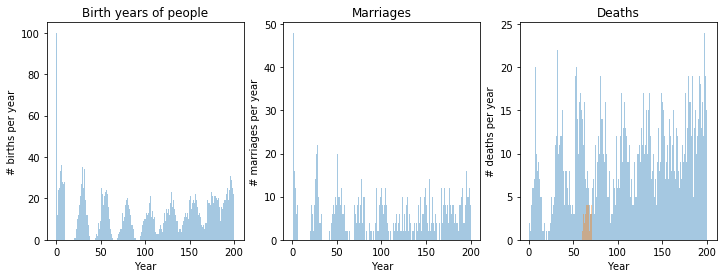

In [138]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))
#sns.set_style("whitegrid")
sns.distplot([min(d.get_events().keys()) for d in terra.library['Person']], kde = False, bins = range(terra.year+2), ax = ax1)
ax1.set_title("Birth years of people")
#plt.subtitle("Third generation is normally distributed.")
ax1.set_xlabel("Year")
ax1.set_ylabel("# births per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if isinstance(l,narrative.MarriageEvent)]
             , kde = False, bins = range(terra.year+2), ax = ax2)
ax2.set_title("Marriages")
#ax2.subtitle("Third generation is normally distributed.")
ax2.set_xlabel("Year")
ax2.set_ylabel("# marriages per year")

sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if terra.library['Person'][i].associated not in plague.killedbyplague and isinstance(l,narrative.DeathEvent)],
             kde = False, bins = range(terra.year+2), ax = ax3)
sns.distplot([l.year for i in range(len(terra.library['Person'])) for x in terra.library['Person'][i].get_events().items() for l in x[1] if terra.library['Person'][i].associated in plague.killedbyplague and isinstance(l,narrative.DeathEvent)],
             kde = False, bins = range(terra.year+2), ax = ax3)
ax3.set_title("Deaths")
#ax2.subtitle("Third generation is normally distributed.")
ax3.set_xlabel("Year")
ax3.set_ylabel("# deaths per year")


print('')

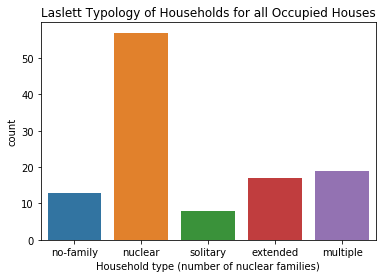

In [139]:
sns.countplot([residency.classify(h) for h in terra.houses if h.people != []])
plt.title('Laslett Typology of Households for all Occupied Houses')
plt.xlabel('Household type (number of nuclear families)')
print('')

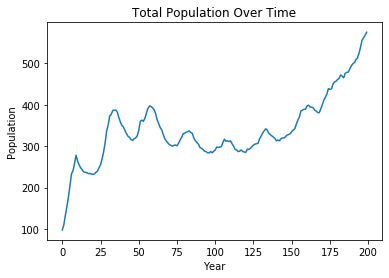

In [140]:
#Population over time
data_x = list(range(terra.year))
data_y = pop_each_year
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Total Population Over Time')
plt.plot(data_x, data_y)

#individual households over time

#number of different households at different population levels

#

In [13]:
killednum = []
seeds = [123, 456, 789]

for d in [5,10]:
    for s in seeds:

        start_pop = 100 #just a few people to start
        start_area = 2000 #lots of room for growth
        start_age = age_of_majority - 1 #so that everyone makes the transition to marriage eligibility on time
        plague = MortalityCrisis(75, d, plaguetab)

        rd.seed(s) #Used here to standardize the example code across runs for any random parts like name generation.
        terra = World()
        sweetwater = Community(world = terra,
                               name = 'Sweetwater',
                               pop = start_pop,
                               area = start_area,
                               startage = start_age,
                               mortab = mortality,
                               birthtab = fertility,
                               marriagerule = marriagerule,
                               inheritancerule = inheritancerule,
                               mobilityrule = mobilityrule,
                               birthrule = birthrule)
        while terra.year < 100: #run for 42 years
            plague(terra)
            terra.progress()
        #write some history
        killednum.append(len(plague.killedbyplague))
print(killednum)


[299, 170, 256, 516, 296, 422]


#### Estimated Average Annual Death Rates for the Antonine Plague

Total Fatality Rate for 165-175 for Entire Empire: 7-10%
    
    7% - Avg Annual rate: 0.0072
    8% - Avg Annual rate: 0.0083
    9% - Avg Annual rate: 0.0094
    10% - Avg Annual rate: 0.0105

Total Fatality Rate for Entire Plague for Cities & Armies: 13-15%
    
    13% - Avg Annual rate: 0.0138
    14% - Avg Annual rate: 0.0149
    15% - Avg Annual rate: 0.0161


In [21]:
k = .07 #killed
nk = 1 - k #not killed
y = 10 #years
p = (nk) ** (1./y)
print(1-p)

0.007230800339783072
